# Implementation of AutoEncoder (AE) (New latent vec for customers)


## AE

- no assumption at latent vec distribution
- bias on latent vec rather than generative ability

python and pytorch version: python=3.7, pytorch=1.3.1

In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

'''
A clustering result satisfies completeness,
if all the data points that are members of a given class are elements of the same cluster.
'''
from sklearn.metrics.cluster import completeness_score

import pandas as pd

import matplotlib.cm as cm
from matplotlib import pyplot as plt

# AE

# For Paul

1. You need to import mnist dataset using the code from 01_Variational_AutoEncoder.ipynb

2. Also, I commented out VAE part, this is only AE

### Step 0. Train : Val : Test  = [6 : 2 : 2]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [43]:
X_train.shape

(5554, 108)

In [44]:
X_test.shape

(2073, 108)

In [45]:
X_val.shape

(2737, 108)

# Model Hyperparameters

In [125]:
# Model Hyperparameters
dataset_path = '../'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 10
hidden_dim = 50
latent_dim = 2 # For visualization
lr = 1e-3
epochs = 30

x_dim  = X_train.shape[1]

###    Step 1. Load (or download) Dataset

In [126]:
from torch.utils.data import TensorDataset

In [127]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

kwargs = {'num_workers': 1, 'pin_memory': True} 

# 
# TensorDataset(X_train)
train_loader = DataLoader(dataset=X_train, batch_size=batch_size, shuffle=True,  **kwargs)
val_loader   = DataLoader(dataset=X_val,   batch_size=batch_size, shuffle=True,  **kwargs)
test_loader  = DataLoader(dataset=X_test,  batch_size=batch_size, shuffle=False, **kwargs)

### Step 2. Define our model: AutoEncoder (AE)

In [1]:
"""
    A simple implementation of MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, latent_dim)
#         self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
#         self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
#         mean     = self.FC_mean(h_)
#         log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        return h_                          

NameError: name 'nn' is not defined

In [129]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, output_dim)
#         self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        x_hat     = self.LeakyReLU(self.FC_hidden2(h))
        
#         x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [130]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        h = self.Encoder(x)
#         z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.Decoder(h)
        
        return x_hat, h

In [131]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)
network = nn.DataParallel(model, device_ids=[0,1]) # Use 2 GPUs

In [132]:
print(model)

Model(
  (Encoder): Encoder(
    (FC_input): Linear(in_features=108, out_features=50, bias=True)
    (FC_input2): Linear(in_features=50, out_features=2, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (Decoder): Decoder(
    (FC_hidden): Linear(in_features=2, out_features=50, bias=True)
    (FC_hidden2): Linear(in_features=50, out_features=108, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)


### Step 3. Define Loss function (reprod. loss) and optimizer

In [133]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat):
    
#     reproduction_loss = BCE_loss(x, x_hat.detach())
#     reproduction_loss = nn.functional.binary_cross_entropy(x_hat, torch.sigmoid(x), reduction='sum')
    reproduction_loss = nn.functional.mse_loss(x_hat, x,)
#     KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss

optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train & val  

In [134]:
def train(model, train_loader):
    '''
    Train an epoch
    Return the total loss for all the samples in this epoch
    '''
    model.train()
    overall_loss = 0
    for batch_idx, x in enumerate(train_loader):
        x = x.float()
        x = x.to(DEVICE)
        optimizer.zero_grad()
        x_hat, _ = model(x)
        loss = loss_function(x, x_hat)
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    return overall_loss

In [135]:
def val(model, val_loader,):
    '''
    Eval an epoch on val_set
    Return the total loss for all the samples in this epoch
    '''
    model.eval()
    overall_loss = 0
    
    with torch.no_grad():
        for batch_idx, x in enumerate(val_loader):
            x = x.float()
            x = x.to(DEVICE)
            x_hat, _ = model(x)
            loss = loss_function(x, x_hat)
            overall_loss += loss.item()
    return overall_loss

In [136]:
def test(model, test_loader):
    '''
    Return the total loss for the test set 
    '''
    model.eval()
    overall_loss = 0
    
    with torch.no_grad():
        for batch_idx, x in enumerate(test_loader):
            x = x.float()
            x = x.to(DEVICE)
            x_hat, _ = model(x)
            
            loss = loss_function(x, x_hat)
            overall_loss += loss.item()
            
    return overall_loss

### Train & Val

In [137]:
print(model)
print("Start training VAE...")

train_losses = []
val_losses = []
lrs = []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       'min', 
                                                       patience=2, 
                                                       factor=0.5)

for epoch in range(epochs):
    
    train_loss = train(model, train_loader)
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    val_loss = val(model, val_loader)
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    lrs.append(scheduler._last_lr[0])
        
    print("\tEpoch", epoch + 1, "complete!", "\tTrain Loss: ", train_loss, "\t Val Loss: ", val_loss)
    
print("Finish!!")

Model(
  (Encoder): Encoder(
    (FC_input): Linear(in_features=108, out_features=50, bias=True)
    (FC_input2): Linear(in_features=50, out_features=2, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (Decoder): Decoder(
    (FC_hidden): Linear(in_features=2, out_features=50, bias=True)
    (FC_hidden2): Linear(in_features=50, out_features=108, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)
Start training VAE...
	Epoch 1 complete! 	Train Loss:  0.005642743902612943 	 Val Loss:  0.0035099377927115508
	Epoch 2 complete! 	Train Loss:  0.0032255168937798625 	 Val Loss:  0.0030428643481636465
	Epoch 3 complete! 	Train Loss:  0.0028533237564706483 	 Val Loss:  0.00277990216214399
	Epoch 4 complete! 	Train Loss:  0.002603062663963792 	 Val Loss:  0.002537951070051756
	Epoch 5 complete! 	Train Loss:  0.0024435458435527082 	 Val Loss:  0.0024506248721555502
	Epoch 6 complete! 	Train Loss:  0.0023391915173033373 	 Val Loss:  0.0023208219002677785
	Epoch 7 complet

### Test results

In [138]:
test_loss = test(model, test_loader)
test_loss /= len(test_loader.dataset)
test_loss

0.001495982186928988

### Plot loss over epoch - Latent_dim=2

Text(0.5, 0, 'Epoch')

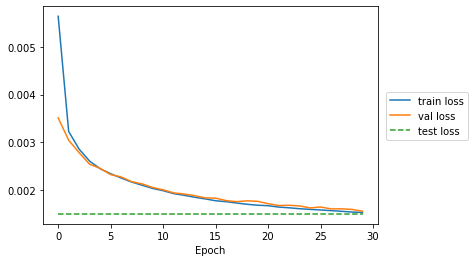

In [139]:
ax, fig = plt.subplots()
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot([test_loss for i in train_losses], '--')
ax.legend(['train loss', 'val loss', 'test loss'], bbox_to_anchor=(1.12,0.5), loc="center right",)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Epoch')

Text(0, 0.5, 'LR')

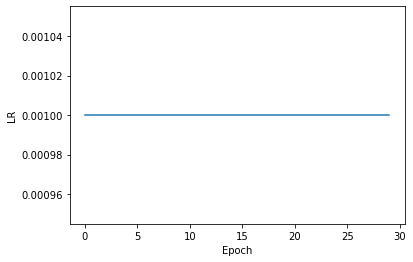

In [140]:
plt.plot(lrs)
plt.xlabel('Epoch')
plt.ylabel('LR')

### Plot loss over epoch - Latent_dim=10
Loss much less than latent_dim=2

Text(0.5, 0, 'Epoch')

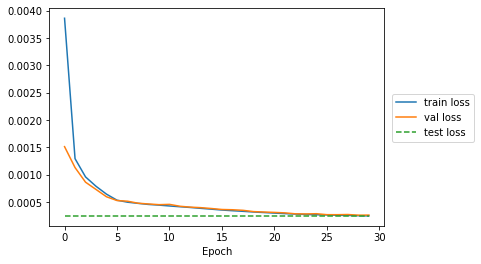

In [108]:
ax, fig = plt.subplots()
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot([test_loss for i in train_losses], '--')
ax.legend(['train loss', 'val loss', 'test loss'], bbox_to_anchor=(1.12,0.5), loc="center right",)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Epoch')

Text(0, 0.5, 'LR')

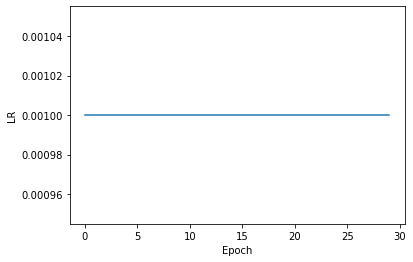

In [109]:
plt.plot(lrs)
plt.xlabel('Epoch')
plt.ylabel('LR')

<!-- ### Step 5. Generate images from test dataset -->
### Step 5. Visualize

In [110]:
def get_latent_vec(X, model):
    '''
    Get latent vec for each sample in the dataset
    
    Input: X: np array, (N, D)
           y: np array, (N, 1)
    
    return: 
           z: np array, (N, D'), where D' << D
    '''
    
    model.eval()
    
#     dataset = TensorDataset( torch.Tensor(X), torch.Tensor(y))
    data_loader = DataLoader(X, batch_size=1, shuffle=False,  **kwargs)
    
    z_list = []
    for i, x in enumerate(data_loader):
        x = x.float()
        x = x.to(DEVICE)
        x_hat, z = model(x)
        z_list.append(z.squeeze(0).cpu().data.numpy())
    return np.array(z_list)

In [111]:
def get_colors(labels):
    '''
    Input: labels, np array, (N, 1)
    Output: colors, np array, (N, d), 
            d is the color prepresentation dim
    '''
    colors = cm.rainbow(np.linspace(0, 1, len(set(labels))))
    color_dict = dict(zip(set(labels), colors))
    all_colors = []
    
    for y in labels:
        all_colors.append(color_dict[y])
        
    return all_colors

In [112]:
def plot_scatters(X, colors):
    '''
    plot X with colors as its labels
    X, np array, (N, 2)
    '''
    for z, c in zip(X, colors):
        plt.scatter(z[0], z[1], color=c )

In [141]:
X_test.shape

(2073, 108)

In [142]:
z_list = get_latent_vec(X_test, model)

In [143]:
z_list.shape

(2073, 2)

## AE (latent_dim=2) + Kmeans

(Not a very good combination)

Text(0.5, 1.0, 'AE dim=2 Ground_truth')

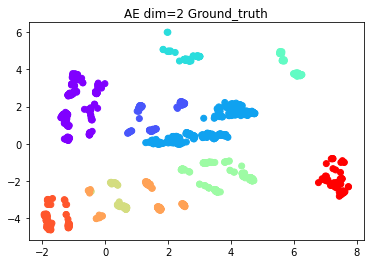

In [145]:
plt.scatter(z_list[:, 0], z_list[:, 1], c=y_test, cmap='rainbow');
plt.title('AE dim=2 Ground_truth')

Text(0.5, 1.0, 'AE dim=2 + KNN')

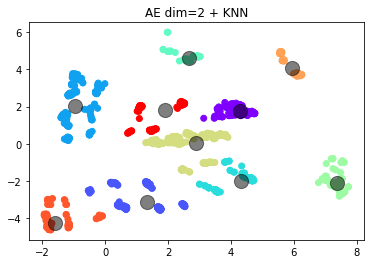

In [147]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(z_list)

y_kmeans = kmeans.predict(z_list)

plt.scatter(z_list[:, 0], z_list[:, 1], c=y_kmeans, cmap='rainbow')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title('AE dim=2 + KNN')

### Measurement of clustering - Completeness score

A clustering result satisfies completeness,
if all the data points that are members of a given class are elements of the same cluster.

e.g.

label = [0, 0, 1, 1]

cluster = [1, 1, 0, 0]

completeness score = 1

- non-negative mutual information

In [148]:
completeness_score(y_test, y_kmeans)

0.8849841948127259

# AE (latent_dim=10) + Kmeans

### Use PCA to visualize latent vec (dim=10)
Loss is less than latent_dim=2, but 2-D projection clusters overlap

Text(0.5, 1.0, 'AE d=10, Ground_truth')

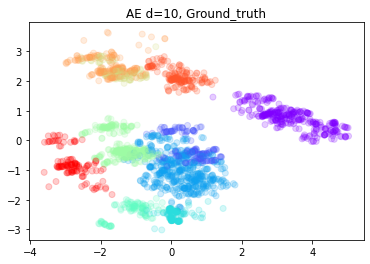

In [119]:
pca = PCA(n_components=2)
pca.fit(np.array(z_list))
Z_new = pca.transform(z_list)
plt.scatter(Z_new[:, 0], Z_new[:, 1], c=y_test, cmap='rainbow', alpha=0.2)
plt.title('AE d=10, Ground_truth')

### Apply K-means on latent_dim=10

Very nice clusters

In [120]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(z_list)
y_kmeans = kmeans.predict(z_list)

Text(0.5, 1.0, 'AE d=10 + Kmeans (PCA visualization in 2d)')

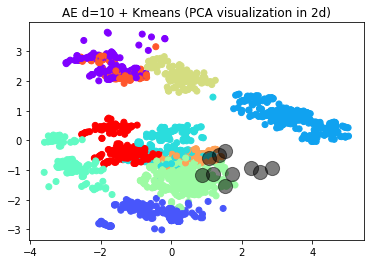

In [121]:
plt.scatter(Z_new[:, 0], Z_new[:, 1], c=y_kmeans, cmap='rainbow')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.title('AE d=10 + Kmeans (PCA visualization in 2d)')

In [124]:
completeness_score(y_test, y_kmeans)

0.9159225645369813

# Raw data KNN

## Visualize raw data based on PCA 

Text(0.5, 1.0, 'groundtruth')

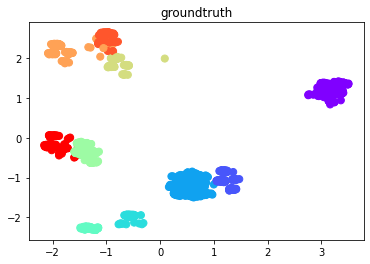

In [149]:
pca = PCA(n_components=2)
pca.fit(X_test)
X_new = pca.transform(X_test)

plt.scatter(X_new[:, 0], X_new[:, 1], c=y_test, s=50, cmap='rainbow')
# plt.scatter(centers_new[:, 0], centers_new[:, 1], c='black', s=200, alpha=0.5);
plt.title('groundtruth')

In [150]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X_test)
y_kmeans = kmeans.predict(X_test)

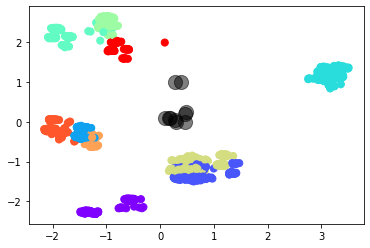

In [151]:
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_kmeans, s=50, cmap='rainbow')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
# plt.title('ground_truth')

In [152]:
completeness_score(y_test, y_kmeans)

0.8683687747567443

# PCA + KNN

Text(0.5, 1.0, 'groundtruth')

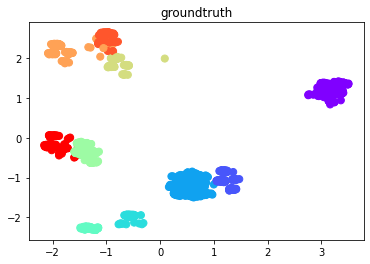

In [153]:
pca = PCA(n_components=2)
pca.fit(X_test)
X_new = pca.transform(X_test)

plt.scatter(X_new[:, 0], X_new[:, 1], c=y_test, s=50, cmap='rainbow')
# plt.scatter(centers_new[:, 0], centers_new[:, 1], c='black', s=200, alpha=0.5);
plt.title('groundtruth')

In [154]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X_new)
y_kmeans = kmeans.predict(X_new)

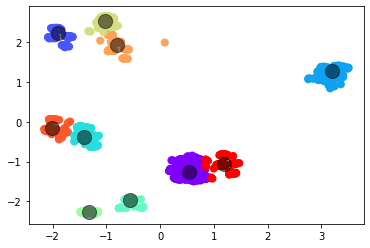

In [155]:
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_kmeans, s=50, cmap='rainbow')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
# plt.title('ground_truth')

In [156]:
completeness_score(y_test, y_kmeans)

0.9667219605019598

In [161]:
X_test_hat = pca.inverse_transform(X_new)

## PCA reconstruction loss

In [162]:
from sklearn.metrics import mean_squared_error

In [163]:
mean_squared_error(X_test, X_test_hat)

0.05035051213651332

# Conclusion
## 1. AE and PCA provides us an option to conduct personalization in individual-level

   ~0.9 completeness score in customerid clustering
   

## 2. AE and PCA 's latent feature yields better clustering scores than raw data

   Better completeness score in Kmeans, 0.91 v.s. 0.86
   

## 3. AE and PCA high dim latent feature has better visualization abibilty than raw data

   Both apply PCA to reduce dim to 2 but AE is very interpretable
   
   
## 4. AE and PCA show competitive results,  while AE doesn't assume linear relations

As bayerj points out PCA is method that assumes linear systems where as Autoencoders (AE) do not. If no non-linear function is used in the AE and the number of neurons in the hidden layer is of smaller dimension then that of the input then PCA and AE can yield the same result. Otherwise the AE may find a different subspace.


https://stats.stackexchange.com/questions/120080/whatre-the-differences-between-pca-and-autoencoder

## More About PCA:

### Pros

PCA reduces the dimensionality without losing information from any features.

Reduce storage space needed to store data

Speed up the learning algorithm (with lower dimension).

Address the multicollinearity issue (all principal components are orthogonal to each other).

Help visualize data with high dimensionality (after reducing the dimension to 2 or 3).

### Cons

Using PCA prevents interpretation of the original features, as well as their impact because eigenvectors are not meaningful.

Potential Use Cases for PCA (not an exhaustive list)

### Use case of PCA

We have many features with high multicollinearity.

We have too many features that cause the algorithm to run very slowly.

### Data Cleaning is Important

PCA is sensitive to outliers and missing values.

### Standardize Data

PCA uses Euclidean distance as its feature vector similarity metric, so make sure we scale the features before applying PCA.

If we use GridSearchCV in the model, make sure we put PCA in Pipeline. Fitting and transforming the training data before running GridSearch lead to data leakage during cross-validation within GridSearch. See detail in my last blog post.


## Difference between PCA and AE

As bayerj points out PCA is method that assumes linear systems where as Autoencoders (AE) do not. If no non-linear function is used in the AE and the number of neurons in the hidden layer is of smaller dimension then that of the input then PCA and AE can yield the same result. Otherwise the AE may find a different subspace.

https://stats.stackexchange.com/questions/120080/whatre-the-differences-between-pca-and-autoencoder

### Step 6. Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [15]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [16]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

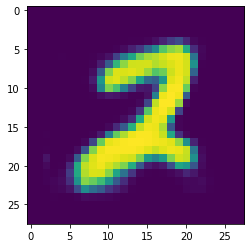

In [17]:
show_image(generated_images, idx=12)